In [144]:
import commentjson
from box import Box
from pprint import pprint
import os
from glob import glob
import multiprocessing
import numpy as np
import cv2
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display, HTML
import tensorflow as tf
import multiprocessing
threads = multiprocessing.cpu_count()
import tensorflow as tf
import copy
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"


In [192]:
def flatten_model(nested_model):
    def get_layers(layers):
        layers_flat = []
        for layer in layers:
            try:
                layers_flat.extend(get_layers(layer.layers))
            except AttributeError:
                layers_flat.append(layer)
        return layers_flat

    flat_model = get_layers(nested_model.layers)
    return flat_model
def _weights(layer):
    weights = layer.get_weights()
    layer_weights = []
    for i, w in enumerate(weights):
        w = np.asarray(w)
        if i < 7:
            layer_weights.append(w)
    return layer_weights

def cal_errs(w):
    vals = np.reshape(w, [-1, w.shape[-1]])
    mins = np.min(vals, axis =0) 
    maxs = np.max(vals, axis =0) 
    fake_q_depth_wise = tf.quantization.fake_quant_with_min_max_vars_per_channel(
                     w,
                     min=np.min(vals, axis =0),
                     max=np.max(vals, axis =0),
                     num_bits=8)
    sq_errs = tf.math.square(fake_q_depth_wise - w)
    mean_errs = tf.math.reduce_mean(sq_errs)
    return tf.math.reduce_sum(sq_errs).numpy(), mean_errs, mins, maxs

In [280]:
cp_dir = "/aidata/anders/objects/landmarks/AFLW/archive_model/all_range_bn/prune_model"
model = tf.keras.models.load_model(cp_dir)

In [281]:
epsilon = tf.keras.backend.epsilon()
model_layers = flatten_model(model)
base_infos = {
    "name":[],
    "depth_wise":[] , 
    "point_wise":[],
    "depth_errs":[],
    "point_errs":[],
    "depth_scale":[],
    "point_scale":[]
}
weights_dict = {}
bit_levels = (1<<8 - 1)

In [282]:
for i, layer in enumerate(model_layers[1:]):
    layer_name = layer.name
    weights = layer.get_weights()
    m = len(weights)
    weights_dict[str(i)] =  base_infos.copy()
    weights_dict[str(i)]["name"] =  layer_name
    if m==2 and 'transpose_up' in layer_name:
        deconv_wise, bias =  weights
        weights_dict[str(i)]["transpose"] = deconv_wise
        square_errs, q_deconv_errs, deconv_mins, deconv_maxs = cal_errs(deconv_wise)

        deconv_scales = abs(deconv_maxs - deconv_mins) / bit_levels
        deconv_scale  = np.mean(deconv_scales)
        weights_dict[str(i)]["transpose_errs"]  = q_deconv_errs.numpy()
        weights_dict[str(i)]["transpose_scale"] = deconv_scale
        weights_dict[str(i)]["transpose_square_errs"] = square_errs
    elif m == 2:
        conv_wise, bias =  weights
        weights_dict[str(i)]["conv_wise"] = conv_wise
        square_errs, q_conv_errs, conv_mins, conv_maxs = cal_errs(conv_wise)
        conv_scales = abs(conv_maxs - conv_mins) / bit_levels
        conv_scale  = np.mean(conv_scales)
        weights_dict[str(i)]["conv_errs"]  = q_conv_errs.numpy()
        weights_dict[str(i)]["conv_scale"] = conv_scale
        weights_dict[str(i)]["conv_square_errs"] = square_errs
    elif m == 3:
        depth_wise, point_wise, bias =  weights
        weights_dict[str(i)]["depth_wise"] = depth_wise
        weights_dict[str(i)]["point_wise"] = point_wise
        square_errs, q_depth_errs, depth_mins, depth_maxs = cal_errs(depth_wise)
        depth_scales = abs(depth_maxs - depth_mins) / bit_levels
        depth_scale  = np.mean(depth_scales)
        weights_dict[str(i)]["depth_errs"]  = q_depth_errs.numpy()
        weights_dict[str(i)]["depth_scale"] = depth_scale
        weights_dict[str(i)]["depth_square_errs"] = square_errs
        
        
        
        square_errs, q_point_errs, point_mins, point_maxs  = cal_errs(point_wise)
        point_scales = abs(point_maxs - point_mins) / bit_levels
        point_scale  = np.mean(point_scales)
        weights_dict[str(i)]["point_errs"]  = q_point_errs.numpy()
        weights_dict[str(i)]["point_scale"] = point_scale
        weights_dict[str(i)]["point_square_errs"] = square_errs


In [283]:
RMSE, layer_names, scales, expected_vals, qerrs = [], [], [], [], []
square_errs = []
for i, key in enumerate(weights_dict):
    if int(key) < 46:
        if 'avg' in weights_dict[key]['name']:
            continue
        # 'backbone'
        depth_name = "{}_{}_{}".format('backbone', "depth_wise", key)
        point_name = "{}_{}_{}".format('backbone', "point_wise", key)
        layer_names += [depth_name] + [point_name]
        square_errs.append(weights_dict[key]["depth_square_errs"])
        qerrs.append(weights_dict[key]["depth_errs"])
        RMSE.append(np.sqrt(weights_dict[key]["depth_errs"]))
        scales.append(weights_dict[key]["depth_scale"])
        expected_vals.append(np.sqrt(weights_dict[key]["depth_errs"]) / weights_dict[key]["depth_scale"] )
        
        
        square_errs.append(weights_dict[key]["point_square_errs"])
        qerrs.append(weights_dict[key]["point_errs"])
        RMSE.append(np.sqrt(weights_dict[key]["point_errs"]))
        scales.append(weights_dict[key]["point_scale"])
        expected_vals.append(np.sqrt(weights_dict[key]["point_errs"]) / weights_dict[key]["point_scale"] )
    elif 55 >= int(key) >= 46:
        if 'avg' in weights_dict[key]['name']:
            continue
        if 'transpose' in  weights_dict[key]['name']:
            name = "{}_{}_{}".format('neck', "tranpose", key)
            square_errs.append(weights_dict[key]["transpose_square_errs"])
            qerrs.append(weights_dict[key]["transpose_errs"])
            RMSE.append(np.sqrt(weights_dict[key]["transpose_errs"]))
            scales.append(weights_dict[key]["transpose_scale"])
            expected_vals.append(np.sqrt(weights_dict[key]["transpose_errs"]) /weights_dict[key]["transpose_scale"] )
            layer_names += [name] 
        elif 'conv' in  weights_dict[key]['name']:
            name = "{}_{}_{}".format('neck', "conv_wise", key)
            square_errs.append(weights_dict[key]["conv_square_errs"])
            qerrs.append(weights_dict[key]["conv_errs"])
            RMSE.append(np.sqrt(weights_dict[key]["conv_errs"]))
            scales.append(weights_dict[key]["conv_scale"])
            expected_vals.append(np.sqrt(weights_dict[key]["conv_errs"]) /weights_dict[key]["conv_scale"] )
            layer_names += [name] 
    elif int(key) > 55:
        if weights_dict[key]['name'] in ["conv_block_45", "conv_block_47", "conv_block_49"]:
            depth_name = "{}_{}_{}".format('head', "depth_wise",key)
            point_name = "{}_{}_{}".format('head', "point_wise",key)
            
            square_errs.append(weights_dict[key]["depth_square_errs"])
            layer_names += [depth_name] + [point_name] 
            qerrs.append(weights_dict[key]["depth_errs"])
            RMSE.append(np.sqrt(weights_dict[key]["depth_errs"]))
            scales.append(weights_dict[key]["depth_scale"])
            expected_vals.append(np.sqrt(weights_dict[key]["depth_errs"]) /weights_dict[key]["depth_scale"] )
            
            square_errs.append(weights_dict[key]["point_square_errs"])
            qerrs.append(weights_dict[key]["point_errs"])
            RMSE.append(np.sqrt(weights_dict[key]["point_errs"]))
            scales.append(weights_dict[key]["point_scale"])
            expected_vals.append(np.sqrt(weights_dict[key]["point_errs"]) /weights_dict[key]["point_scale"] )
        else:
            name = "{}_{}_{}".format('neck', "conv_wise", key)
            square_errs.append(weights_dict[key]["conv_square_errs"])
            qerrs.append(weights_dict[key]["conv_errs"])
            RMSE.append(np.sqrt(weights_dict[key]["conv_errs"]))
            scales.append(weights_dict[key]["conv_scale"])
            expected_vals.append(np.sqrt(weights_dict[key]["conv_errs"]) /weights_dict[key]["conv_scale"] )
            layer_names += [name] 

In [284]:
pd_frames = {"layer_names":layer_names,  "exected_values" : expected_vals, "square_errs":square_errs}
df = pd.DataFrame(pd_frames)
display(HTML(df.to_html()))

,layer_names,exected_values,square_errs
0,backbone_depth_wise_0,0.145901,0.006341
1,backbone_point_wise_0,3.017509,0.035970
2,backbone_depth_wise_1,0.148651,0.020879
3,backbone_point_wise_1,0.153939,0.000169
4,backbone_depth_wise_3,0.145304,0.032527
5,backbone_point_wise_3,0.157593,0.000072
6,backbone_depth_wise_4,0.145034,0.045997
7,backbone_point_wise_4,0.154737,0.000533
8,backbone_depth_wise_5,0.142400,0.008054
9,backbone_point_wise_5,0.149705,0.000012


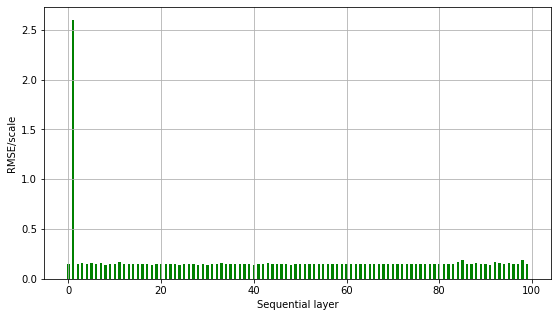

In [285]:
# 0 / 6/ 98/
pd_frames['exected_values'][1] = 2.6
plt.figure(figsize=(20, 5))
ax1 = plt.subplot(121)
ax1.bar(np.arange(len(layer_names)), pd_frames['exected_values'], width = 0.5, color='green')
ax1.set_ylabel('RMSE/scale')
ax1.set_xlabel('Sequential layer')
plt.grid()
#TODO: sum errors

Text(0.5, 1.0, 'Weights vs Counts')

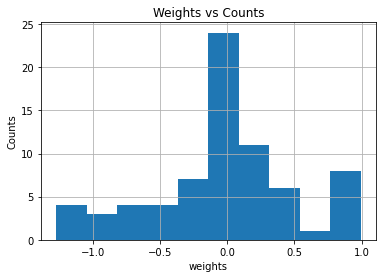

In [286]:
plt.hist(weights_dict['0']['point_wise'].reshape([-1]))
plt.ioff()
plt.grid()
plt.xlabel(r"weights")
plt.ylabel("Counts")
plt.title('Weights vs Counts')

In [269]:

cp_dir = "/aidata/anders/objects/landmarks/AFLW/archive_model/noDIV"
model = tf.keras.models.load_model(cp_dir)
epsilon = tf.keras.backend.epsilon()
model_layers = flatten_model(model)
base_infos = {
    "name":[],
    "depth_wise":[] , 
    "point_wise":[],
    "depth_errs":[],
    "point_errs":[],
    "depth_scale":[],
    "point_scale":[]
}
weights_dict = {}
bit_levels = (1<<8 - 1)

In [270]:
# modified batch normalization version

for i, layer in enumerate(model_layers[1:]):
    layer_name = layer.name
    weights = layer.get_weights()
    m = len(weights)
    
    weights_dict[str(i)] =  base_infos.copy()
    weights_dict[str(i)]["name"] =  layer_name
    #TOD:
    if m == 1:
        conv_wise =  weights[0]
        weights_dict[str(i)]["conv_wise"] = conv_wise
        square_errs, q_conv_errs, conv_mins, conv_maxs = cal_errs(conv_wise)
        conv_scales = abs(conv_maxs - conv_mins) / bit_levels
        conv_scale  = np.mean(conv_scales)
        weights_dict[str(i)]["conv_errs"]  = q_conv_errs.numpy()
        weights_dict[str(i)]["conv_scale"] = conv_scale
        weights_dict[str(i)]["conv_square_errs"] = square_errs
        
    elif m == 2:
        conv_wise, bias =  weights
        weights_dict[str(i)]["conv_wise"] = conv_wise
        square_errs, q_conv_errs, conv_mins, conv_maxs = cal_errs(conv_wise)
        conv_scales = abs(conv_maxs - conv_mins) / bit_levels
        conv_scale  = np.mean(conv_scales)
        weights_dict[str(i)]["conv_errs"]  = q_conv_errs.numpy()
        weights_dict[str(i)]["conv_scale"] = conv_scale
        weights_dict[str(i)]["conv_square_errs"] = square_errs
        
    elif m == 5:
        conv_wise, gamma, beta, moving_mean, moving_variance =  weights
        if 'transpose' in layer_name:
            deconv_wise = np.transpose(conv_wise, [0, 1, 3, 2])
            deconv_wise  = deconv_wise * gamma / (np.sqrt(moving_variance) + epsilon)
            weights_dict[str(i)]["transpose"] = deconv_wise
            square_errs, q_deconv_errs, deconv_mins, deconv_maxs = cal_errs(deconv_wise)
            deconv_scales = abs(deconv_maxs - deconv_mins) / bit_levels
            deconv_scale  = np.mean(deconv_scales)
            weights_dict[str(i)]["transpose_errs"]  = q_deconv_errs.numpy()
            weights_dict[str(i)]["transpose_scale"] = deconv_scale
            weights_dict[str(i)]["transpose_square_errs"] = square_errs
        else:
            
            conv_wise  = conv_wise * gamma / (np.sqrt(moving_variance) + epsilon)
            weights_dict[str(i)]["conv_wise"] = conv_wise
            square_errs, q_conv_errs, conv_mins, conv_maxs = cal_errs(conv_wise)
            conv_scales = abs(conv_maxs - conv_mins) / bit_levels
            conv_scale  = np.mean(conv_scales)
            weights_dict[str(i)]["conv_errs"]  = q_conv_errs.numpy()
            weights_dict[str(i)]["conv_scale"] = conv_scale
            weights_dict[str(i)]["conv_square_errs"] = square_errs
    elif m == 6:
        depth_wise, point_wise, gamma, beta, moving_mean, moving_variance=  weights
        point_wise  = point_wise * gamma / (np.sqrt(moving_variance) + epsilon)
        weights_dict[str(i)]["depth_wise"] = depth_wise
        weights_dict[str(i)]["point_wise"] = point_wise
        square_errs, q_depth_errs, depth_mins, depth_maxs = cal_errs(depth_wise)
        depth_scales = abs(depth_maxs - depth_mins) / bit_levels
        depth_scale  = np.mean(depth_scales)
        weights_dict[str(i)]["depth_errs"]  = q_depth_errs.numpy()
        weights_dict[str(i)]["depth_scale"] = depth_scale
        weights_dict[str(i)]["depth_square_errs"] = square_errs
        square_errs, q_point_errs, point_mins, point_maxs  = cal_errs(point_wise)
        point_scales = abs(point_maxs - point_mins) / bit_levels
        point_scale  = np.mean(point_scales)
        weights_dict[str(i)]["point_errs"]  = q_point_errs.numpy()
        weights_dict[str(i)]["point_scale"] = point_scale
        weights_dict[str(i)]["point_square_errs"] = square_errs
    elif m == 7:
        depth_wise, point_wise, bias, gamma, beta, moving_mean, moving_variance=  weights
        point_wise  = point_wise * gamma / (np.sqrt(moving_variance) + epsilon)
        weights_dict[str(i)]["depth_wise"] = depth_wise
        weights_dict[str(i)]["point_wise"] = point_wise
        square_errs, q_depth_errs, depth_mins, depth_maxs = cal_errs(depth_wise)
        depth_scales = abs(depth_maxs - depth_mins) / bit_levels
        depth_scale  = np.mean(depth_scales)
        weights_dict[str(i)]["depth_errs"]  = q_depth_errs.numpy()
        weights_dict[str(i)]["depth_scale"] = depth_scale
        weights_dict[str(i)]["depth_square_errs"] = square_errs
        square_errs, q_point_errs, point_mins, point_maxs  = cal_errs(point_wise)
        point_scales = abs(point_maxs - point_mins) / bit_levels
        point_scale  = np.mean(point_scales)
        weights_dict[str(i)]["point_errs"]  = q_point_errs.numpy()
        weights_dict[str(i)]["point_scale"] = point_scale
        weights_dict[str(i)]["point_square_errs"] = square_errs


In [271]:
RMSE, layer_names, scales, expected_vals, qerrs = [], [], [], [], []
square_errs = []
for i, key in enumerate(weights_dict):
    
    if int(key) < 46:
        if 'avg' in weights_dict[key]['name']:
            continue
        # 'backbone'
        depth_name = "{}_{}_{}".format('backbone', "depth_wise", key)
        point_name = "{}_{}_{}".format('backbone', "point_wise", key)
        layer_names += [depth_name] + [point_name] 
        square_errs.append(weights_dict[key]["depth_square_errs"])
        qerrs.append(weights_dict[key]["depth_errs"])
        RMSE.append(np.sqrt(weights_dict[key]["depth_errs"]))
        scales.append(weights_dict[key]["depth_scale"])
        expected_vals.append(np.sqrt(weights_dict[key]["depth_errs"]) / weights_dict[key]["depth_scale"] )
        
        
        square_errs.append(weights_dict[key]["point_square_errs"])
        qerrs.append(weights_dict[key]["point_errs"])
        RMSE.append(np.sqrt(weights_dict[key]["point_errs"]))
        scales.append(weights_dict[key]["point_scale"])
        expected_vals.append(np.sqrt(weights_dict[key]["point_errs"]) / weights_dict[key]["point_scale"] )
    elif 55 >= int(key) >= 46:
        
        if 'avg' in weights_dict[key]['name']:
            continue
        if 'transpose' in  weights_dict[key]['name']:
            name = "{}_{}_{}".format('neck', "tranpose", key)
            square_errs.append(weights_dict[key]["transpose_square_errs"])
            qerrs.append(weights_dict[key]["transpose_errs"])
            RMSE.append(np.sqrt(weights_dict[key]["transpose_errs"]))
            scales.append(weights_dict[key]["transpose_scale"])
            expected_vals.append(np.sqrt(weights_dict[key]["transpose_errs"]) /weights_dict[key]["transpose_scale"] )
            layer_names += [name] 
        elif 'conv' in  weights_dict[key]['name']:
            name = "{}_{}_{}".format('neck', "conv_wise", key)
            square_errs.append(weights_dict[key]["conv_square_errs"])
            qerrs.append(weights_dict[key]["conv_errs"])
            RMSE.append(np.sqrt(weights_dict[key]["conv_errs"]))
            scales.append(weights_dict[key]["conv_scale"])
            expected_vals.append(np.sqrt(weights_dict[key]["conv_errs"]) /weights_dict[key]["conv_scale"] )
            layer_names += [name] 
    elif int(key) > 55:
        if weights_dict[key]['name'] in ["conv_block_45", "conv_block_47", "conv_block_49"]:
            depth_name = "{}_{}_{}".format('head', "depth_wise",key)
            point_name = "{}_{}_{}".format('head', "point_wise",key)
            
            square_errs.append(weights_dict[key]["depth_square_errs"])
            layer_names += [depth_name] + [point_name] 
            qerrs.append(weights_dict[key]["depth_errs"])
            RMSE.append(np.sqrt(weights_dict[key]["depth_errs"]))
            scales.append(weights_dict[key]["depth_scale"])
            expected_vals.append(np.sqrt(weights_dict[key]["depth_errs"]) /weights_dict[key]["depth_scale"] )
            
            square_errs.append(weights_dict[key]["point_square_errs"])
            qerrs.append(weights_dict[key]["point_errs"])
            RMSE.append(np.sqrt(weights_dict[key]["point_errs"]))
            scales.append(weights_dict[key]["point_scale"])
            expected_vals.append(np.sqrt(weights_dict[key]["point_errs"]) /weights_dict[key]["point_scale"] )
        else:
            name = "{}_{}_{}".format('neck', "conv_wise", key)
            square_errs.append(weights_dict[key]["conv_square_errs"])
            qerrs.append(weights_dict[key]["conv_errs"])
            RMSE.append(np.sqrt(weights_dict[key]["conv_errs"]))
            scales.append(weights_dict[key]["conv_scale"])
            expected_vals.append(np.sqrt(weights_dict[key]["conv_errs"]) /weights_dict[key]["conv_scale"] )
            layer_names += [name] 

In [272]:
pd_frames = {"layer_names":layer_names,  "exected_values" : expected_vals, "square_errs":square_errs}
df = pd.DataFrame(pd_frames)
display(HTML(df.to_html()))

,layer_names,exected_values,square_errs
0,backbone_depth_wise_0,0.130155,0.005014
1,backbone_point_wise_0,3.285608,0.143417
2,backbone_depth_wise_1,0.149790,0.020832
3,backbone_point_wise_1,0.149460,0.000254
4,backbone_depth_wise_3,0.144349,0.035831
5,backbone_point_wise_3,0.155817,0.000076
6,backbone_depth_wise_4,0.145467,0.046169
7,backbone_point_wise_4,0.150512,0.000337
8,backbone_depth_wise_5,0.142301,0.008339
9,backbone_point_wise_5,0.152804,0.000021


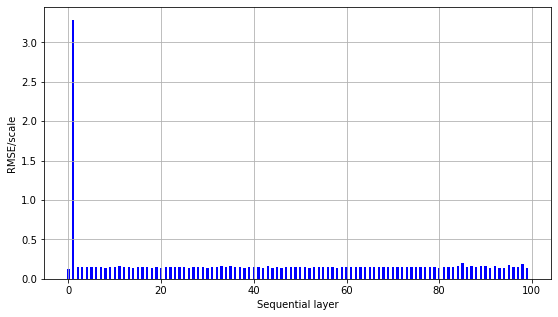

In [275]:
# 1 / 85 / 98/
plt.figure(figsize=(20, 5))
ax1 = plt.subplot(121)
ax1.bar(np.arange(len(layer_names)), pd_frames['exected_values'], width = 0.5, color='blue')
ax1.set_ylabel('RMSE/scale')
ax1.set_xlabel('Sequential layer')
plt.grid()
#TODO: sum errors

Text(0.5, 1.0, 'Weights vs Counts')

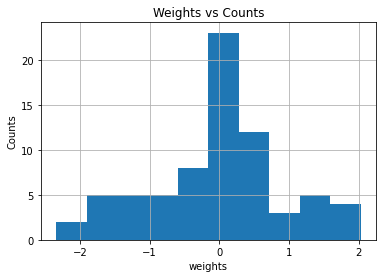

In [279]:
plt.hist(weights_dict['0']['point_wise'].reshape([-1]))
plt.ioff()
plt.grid()
plt.xlabel(r"weights")
plt.ylabel("Counts")
plt.title('Weights vs Counts')

Text(0.5, 1.0, 'init layer Weights vs Counts')

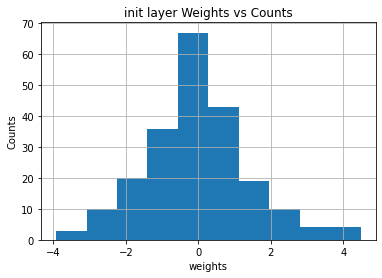

In [142]:
#
vals = np.reshape(new_depth_wise, [-1, weights_dict["point_wise"].shape[-1]])
fake_q_depth_wise = tf.quantization.fake_quant_with_min_max_vars_per_channel(
      vals,
     min=np.min(vals, axis =0),
     max=np.max(vals, axis =0),
     num_bits=8)

sq_errs = tf.math.abs(fake_q_depth_wise - vals)
errs = tf.math.reduce_sum(sq_errs)
print(errs)



# for depth_wise part
plt.hist(weights_dict["depth_wise"].reshape([-1]))
plt.ioff()
plt.grid()
plt.xlabel(r"weights")
plt.ylabel("Counts")
plt.title('init layer Weights vs Counts')

# Point_wise 

Text(0.5, 1.0, 'init layer Weights vs Counts')

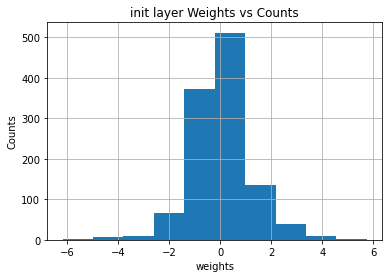

In [143]:
plt.hist(weights_dict["point_wise"].reshape([-1]))
plt.ioff()
plt.grid()
plt.xlabel(r"weights")
plt.ylabel("Counts")
plt.title('init layer Weights vs Counts')

In [144]:
vals = np.reshape(new_depth_wise, [-1, weights_dict["depth_wise"].shape[-1]])
fake_q_depth_wise = tf.quantization.fake_quant_with_min_max_vars_per_channel(
      vals,
     min=np.min(vals, axis =0),
     max=np.max(vals, axis =0),
     num_bits=8)

sq_errs = tf.math.abs(fake_q_depth_wise - vals)
errs = tf.math.reduce_sum(sq_errs)
print(errs)

tf.Tensor(10.439314, shape=(), dtype=float32)


In [145]:
vals = np.reshape(new_depth_wise, [-1, weights_dict["point_wise"].shape[-1]])
fake_q_depth_wise = tf.quantization.fake_quant_with_min_max_vars_per_channel(
      vals,
     min=np.min(vals, axis =0),
     max=np.max(vals, axis =0),
     num_bits=8)

sq_errs = tf.math.abs(fake_q_depth_wise - vals)
errs = tf.math.reduce_sum(sq_errs)
print(errs)

tf.Tensor(6.5608754, shape=(), dtype=float32)


Text(0.5, 1.0, 'init layer Weights vs Counts')

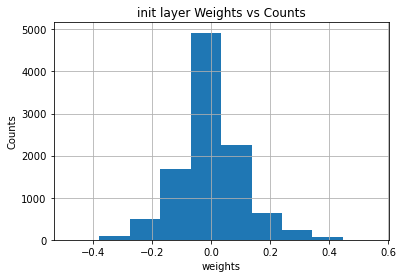